In [1]:
import easystac as es
import json
from  shapely.geometry import shape
import stackstac
import pystac_client
%matplotlib inline
import matplotlib.pyplot as plt

Reading GeoJSON

In [2]:
with open('remote_sensing_challenge_AOI.geojson') as file:
    geo_file =  json.load(file)
    features = geo_file['features']
    for feat in features:
        geom = shape(feat['geometry'])

Getting the Imge

In [3]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

queries = {
    "eo:cloud_cover": {
        "gte": 0,
        "lte": 20
    }
}

stac_items = catalog.search(
    intersects=geom,
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2022-06-01/2022-07-01",
    query=queries
).get_all_items()

collection = stackstac.stack(stac_items, epsg=4326)
collection

,Array,Chunk
Bytes,249.68 GiB,8.00 MiB
Shape,"(8, 17, 11708, 21046)","(1, 1, 1024, 1024)"
Count,3 Graph Layers,34272 Chunks
Type,float64,numpy.ndarray


Clipping to extent

In [4]:
# Getting the extent

min_lon = geom.bounds[0]
min_lat = geom.bounds[1]
max_lon = geom.bounds[2]
max_lat = geom.bounds[3]

# Cropping the xarray
mask_lon = (collection.x >= min_lon) & (collection.x <= max_lon)
mask_lat = (collection.y >= min_lat) & (collection.y <= max_lat)

cropped_dc = collection.where(mask_lon & mask_lat, drop=True)
cropped_dc

,Array,Chunk
Bytes,0.98 GiB,4.12 MiB
Shape,"(8, 17, 1578, 613)","(1, 1, 1024, 528)"
Count,8 Graph Layers,816 Chunks
Type,float64,numpy.ndarray


In [5]:
s2_20m = cropped_dc.sel(band=['B05','B06','B07','B8A','B11','B12', 'SCL'])
s2_20m

<xarray.DataArray 'stackstac-c4d939d78f92ae75ff35791f558e4a36' (time: 8,
                                                                band: 7,
                                                                y: 1578, x: 613)>
dask.array<getitem, shape=(8, 7, 1578, 613), dtype=float64, chunksize=(1, 1, 1024, 528), chunktype=numpy.ndarray>
Coordinates: (12/28)
  * time                          (time) datetime64[ns] 2022-06-10T10:26:14 ....
    id                            (time) <U24 'S2A_33UVU_20220610_0_L2A' ... ...
  * band                          (band) <U8 'B05' 'B06' 'B07' ... 'B12' 'SCL'
  * x                             (x) float64 13.48 13.48 13.48 ... 13.57 13.57
  * y                             (y) float64 52.62 52.62 52.62 ... 52.47 52.47
    sentinel:processing_baseline  <U5 '04.00'
    ...                            ...
    updated                       (time) <U24 '2022-06-10T20:01:01.360Z' ... ...
    title                         (band) <U31 'Band 5' ... 'Scene Classificat...
    common_name                   (band) object None None None ... 'swir22' None
    center_wavelength             (band) object 0.7039 0.7402 ... 2.22024 None
    full_width_half_max           (band) object 0.019 0.018 0.028 ... 0.242 None
    epsg                          int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(11.927775264970792, 52.1754...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 11.93|\n| 0.00,-0.00, 53.25|\n| 0.00, 0.00,...
    resolution_xy:  (0.00015292999890981207, 9.17437479444061e-05)

Mask unusable data with the Sentinel-2 SCL layer - Please convert all values of the S-2 spectral bands to nodata/NA values for which there are NO_DATA, SATURATED_OR_DEFECTIVE, CLOUD_HIGH_PROBABILITY values in the S-2 SCL layer

In [6]:
import numpy as np
a = s2_20m.sel(band="SCL").isin([0,1,9])
dc_masked = s2_20m.where(a, np.nan).sel(band=['B05','B06','B07','B8A','B11','B12'])
dc_masked

<xarray.DataArray 'stackstac-c4d939d78f92ae75ff35791f558e4a36' (time: 8,
                                                                band: 6,
                                                                y: 1578, x: 613)>
dask.array<getitem, shape=(8, 6, 1578, 613), dtype=float64, chunksize=(1, 1, 1024, 528), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * time                          (time) datetime64[ns] 2022-06-10T10:26:14 ....
    id                            (time) <U24 'S2A_33UVU_20220610_0_L2A' ... ...
  * band                          (band) <U8 'B05' 'B06' 'B07' 'B8A' 'B11' 'B12'
  * x                             (x) float64 13.48 13.48 13.48 ... 13.57 13.57
  * y                             (y) float64 52.62 52.62 52.62 ... 52.47 52.47
    sentinel:processing_baseline  <U5 '04.00'
    ...                            ...
    created                       (time) <U24 '2022-06-10T20:01:01.360Z' ... ...
    sentinel:product_id           (time) <U60 'S2A_MSIL2A_20220610T101611_N04...
    sentinel:data_coverage        (time) float64 68.09 100.0 ... 67.92 63.85
    sentinel:valid_cloud_cover    bool True
    updated                       (time) <U24 '2022-06-10T20:01:01.360Z' ... ...
    epsg                          int64 4326
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(11.927775264970792, 52.1754...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 11.93|\n| 0.00,-0.00, 53.25|\n| 0.00, 0.00,...
    resolution_xy:  (0.00015292999890981207, 9.17437479444061e-05)

(array([ 1152., 16894., 53325., 86132., 79878., 52906., 29551., 18449.,
         5185.,   958.]),
 array([1230. , 1960.2, 2690.4, 3420.6, 4150.8, 4881. , 5611.2, 6341.4,
        7071.6, 7801.8, 8532. ]),
 <BarContainer object of 10 artists>)

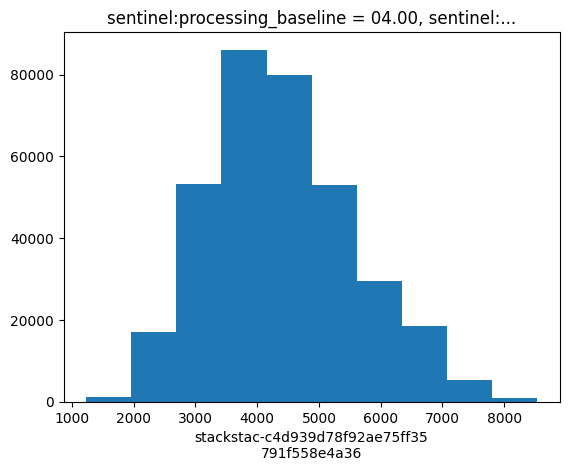

In [7]:
dc_masked.plot()

Recuding Image

In [8]:
result = dc_masked.reduce(np.mean,'time')
result.to_netcdf('result_part1.nc')

In [9]:
result

<xarray.DataArray 'stackstac-c4d939d78f92ae75ff35791f558e4a36' (band: 6,
                                                                y: 1578, x: 613)>
dask.array<mean_agg-aggregate, shape=(6, 1578, 613), dtype=float64, chunksize=(1, 1024, 528), chunktype=numpy.ndarray>
Coordinates:
  * band                          (band) <U8 'B05' 'B06' 'B07' 'B8A' 'B11' 'B12'
  * x                             (x) float64 13.48 13.48 13.48 ... 13.57 13.57
  * y                             (y) float64 52.62 52.62 52.62 ... 52.47 52.47
    sentinel:processing_baseline  <U5 '04.00'
    sentinel:sequence             <U1 '0'
    constellation                 <U10 'sentinel-2'
    instruments                   <U3 'msi'
    sentinel:latitude_band        <U1 'U'
    sentinel:boa_offset_applied   bool True
    view:off_nadir                int64 0
    sentinel:valid_cloud_cover    bool True
    epsg                          int64 4326

In [10]:
# import rioxarray as rx
# nc2geotiff = rx.open_rasterio('result_part1.nc')
# nc2geotiff.rio.to_raster('output.tif')

/Users/Jorge/Documents/tmp/chanllenge_LEO/env/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/Jorge/Documents/tmp/chanllenge_LEO/env/lib/python3.9/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Users/Jorge/Documents/tmp/chanllenge_LEO/env/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/Jorge/Documents/tmp/chanllenge_LEO/env/lib/python3.9/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, 

MissingDimensionsError: 'band' has more than 1-dimension and the same name as one of its dimensions ('band', 'y', 'x'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

POINT 2

Normalization

The normalization of variables is essential to reduce context effects, i.e. to better understand each other's data and their behavior. In multitemporal subjects, the value of a pixel is affected by the conditions of the environment, sensor, so the same object can have two different absolute values between shots. For this reason, normalization aims to diminish this effect. Normalization can be calculated in different ways, the best known is the mean, max-min , l1. Depending on the purpose of use different normalizations may be more convenient.

In [39]:
from xarray import apply_ufunc

def mean_norm(array):
    max= np.max(array)
    min= np.min(array)
    mean=np.mean(array)
    new = (array - mean) / (max-min)
    return new

def meanNorm(array):
    return apply_ufunc(
        mean_norm,
        array,
        dask = 'allowed'
    )    
# L1 Normalization
meanN = meanNorm(result)
meanN

<xarray.DataArray 'stackstac-c4d939d78f92ae75ff35791f558e4a36' (band: 6,
                                                                y: 1578, x: 613)>
dask.array<truediv, shape=(6, 1578, 613), dtype=float64, chunksize=(1, 1024, 528), chunktype=numpy.ndarray>
Coordinates:
  * band                          (band) <U8 'B05' 'B06' 'B07' 'B8A' 'B11' 'B12'
  * x                             (x) float64 13.48 13.48 13.48 ... 13.57 13.57
  * y                             (y) float64 52.62 52.62 52.62 ... 52.47 52.47
    sentinel:processing_baseline  <U5 '04.00'
    sentinel:sequence             <U1 '0'
    constellation                 <U10 'sentinel-2'
    instruments                   <U3 'msi'
    sentinel:latitude_band        <U1 'U'
    sentinel:boa_offset_applied   bool True
    view:off_nadir                int64 0
    sentinel:valid_cloud_cover    bool True
    epsg                          int64 4326

In [40]:
from xarray import apply_ufunc

def robust_scalar_norm(array):
    median= np.quantile(array, 0.5)
    q1= np.quantile(array, 0.25)
    q3= np.quantile(array, 0,75)
    new = (array - median) / (q3-q1)
    return new

def robustNorm(array):
    return apply_ufunc(
        robust_scalar_norm,
        array,
        dask = 'allowed'
    )    
# L1 Normalization
robustN = robustNorm(result)
robustN

NotImplementedError: The da.median function only works along an axis.  The full algorithm is difficult to do in parallel

Estandarisation

In [20]:
def est(array):
    mean=np.mean(array)
    std=np.std(array)
    new = (array - mean) / std
    return new

def estArray(array):
    return apply_ufunc(
        est,
        array,
        dask = 'allowed',
    )
estandarization = estArray(result)

<xarray.DataArray 'stackstac-c4d939d78f92ae75ff35791f558e4a36' (band: 6,
                                                                y: 1578, x: 613)>
dask.array<truediv, shape=(6, 1578, 613), dtype=float64, chunksize=(1, 1024, 528), chunktype=numpy.ndarray>
Coordinates:
  * band                          (band) <U8 'B05' 'B06' 'B07' 'B8A' 'B11' 'B12'
  * x                             (x) float64 13.48 13.48 13.48 ... 13.57 13.57
  * y                             (y) float64 52.62 52.62 52.62 ... 52.47 52.47
    sentinel:processing_baseline  <U5 '04.00'
    sentinel:sequence             <U1 '0'
    constellation                 <U10 'sentinel-2'
    instruments                   <U3 'msi'
    sentinel:latitude_band        <U1 'U'
    sentinel:boa_offset_applied   bool True
    view:off_nadir                int64 0
    sentinel:valid_cloud_cover    bool True
    epsg                          int64 4326

In [ ]:
for band in estandarization.band:
    estandarization.sel(band=band.values).plot.scatter() #
plt.legend()

Point 3

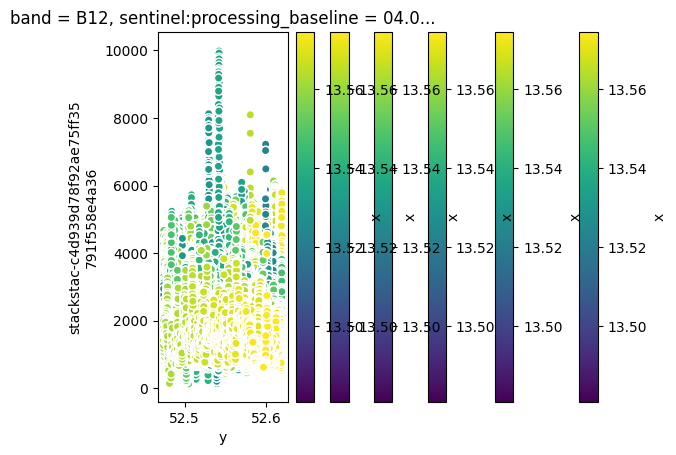

In [38]:
# Water
water = s2_20m.where(s2_20m.sel(band="SCL") != 6, np.nan).sel(band=['B05','B06','B07','B8A','B11','B12'])
water =  water.reduce(np.mean, 'time')
for band in water.band:
    water.sel(band=band.values).plot.scatter() 

In [ ]:
# Vegetation
veg = s2_20m.where(s2_20m.sel(band="SCL") != 4, np.nan).sel(band=['B05','B06','B07','B8A','B11','B12'])

In [ ]:
# Not_Vegetated
nveg = s2_20m.where(s2_20m.sel(band="SCL") != 5, np.nan).sel(band=['B05','B06','B07','B8A','B11','B12'])